In [1]:
from uilc import utils

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import math

In [3]:
def lambertian(x, t, s, H):
    k = (x-t)/H
    base = (H**2)*(1 + k**2)**(s/2 +1)
    return np.power(base, -1)

In [4]:
utils.radiation.lambertian(0, 4, 1, 1)

0.01426680147272547

In [5]:
utils.radiation.lambertian(np.array([0, 1 , 3]), 4, 1, 1)

0.399442968667683

In [6]:
2*utils.radiation.lambertian(math.sqrt(2), 0, 1, 1)

0.3849001794597504

In [7]:
utils.radiation.lambertian2d([[1,1],[-1,1]], np.array([[[0]],[[0]]]), 1, 1)

/Users/hyunseongkim/miniconda3/envs/uilc/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[0.38490018]])

In [367]:
# Radiation argument
s = 80
# Geometric system
H = 0.8
Wx = 1.6
Wy = 2.4
# Discretization argument
nx, ny =40, 80
kx, ky = 2*nx-1, 2*ny-1
#d = lambda i, j, n: (math.floor(n/2)-i)**2 + (math.floor(n/2)-j)**2
#dw = [Wx/n, Wy/n]

In [368]:
X, Y = utils.misc.plane_meshgrid([-Wx/2, Wx/2], [-Wy/2, Wy/2], [kx, ky], endpoints=[True, True])

In [369]:
filter = utils.radiation.lambertian2d(np.array([0,0]), [X,Y], s, H)

[-0.8, 0.8, -1.2, 1.2]

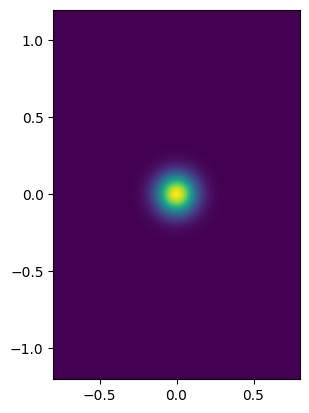

In [370]:
extent_xy = [-Wx/2, Wx/2, -Wy/2, Wy/2]
plt.imshow(filter, extent=extent_xy )
extent_xy 

In [371]:
filter.shape

(159, 79)

In [372]:
(nx, ny)

(40, 80)

In [373]:
from scipy.optimize import nnls

In [374]:
filter_mat = utils.convolution.get_matrix_system(filter.T, (nx, ny))

In [375]:
sol_nnls = nnls(filter_mat, np.ones(filter_mat.shape[0]))
sol_2d = sol_nnls[0].reshape(nx, ny)

In [376]:
illu_2d = (filter_mat@sol_nnls[0]).reshape(nx,ny)

Text(0.5, 1.0, 'illumination map')

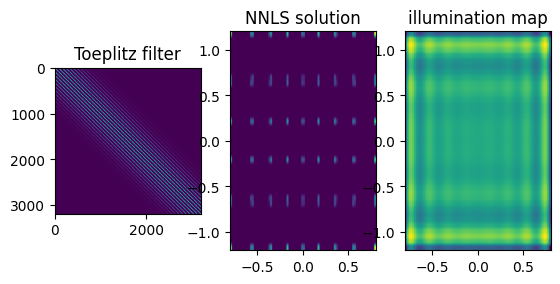

In [377]:
fig, axs = plt.subplots(1, 3)

axs[0].imshow(filter_mat)
axs[0].set_title("Toeplitz filter")

axs[1].imshow(sol_2d, extent= extent_xy)
axs[1].set_title("NNLS solution")

axs[2].imshow(illu_2d, extent = extent_xy)
axs[2].set_title("illumination map")

In [378]:
xarr = np.linspace(-Wx/2, Wx/2, nx, endpoint=True) 
yarr = np.linspace(-Wy/2, Wy/2, ny, endpoint=True)

X, Y = np.meshgrid(xarr, yarr)

(0.0, 1.3)

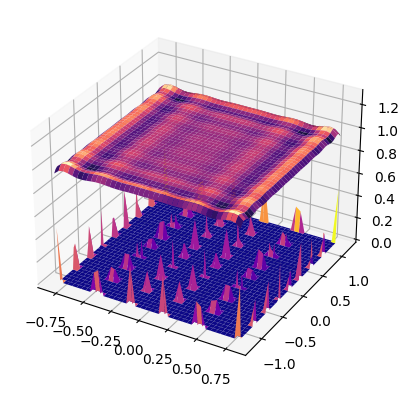

In [379]:
fig, ax = plt.subplots(subplot_kw = {"projection": "3d"})
ax.plot_surface(X, Y, illu_2d.T, zorder=-1, cmap="magma")

ax.plot_surface(X, Y, sol_2d.T, zorder=-1, cmap="plasma")
ax.set_zlim(0, 1.3)

In [380]:
from uilc.utils import invsam

In [381]:
blur_filter = utils.radiation.lambertian2d(np.array([0,0]), [X,Y], s, H/2)

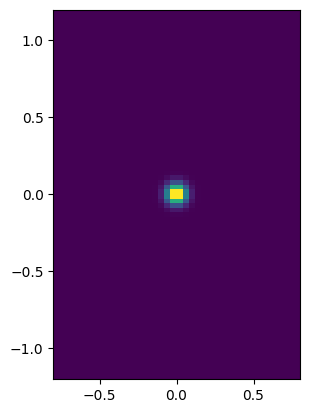

In [382]:
plt.imshow(blur_filter, extent=extent_xy)

In [398]:
pmf = utils.convolution.convolve2d(sol_2d, blur_filter)
cdf = invsam.pmf2cdf_2d(pmf)
cdf = cdf/cdf.max()

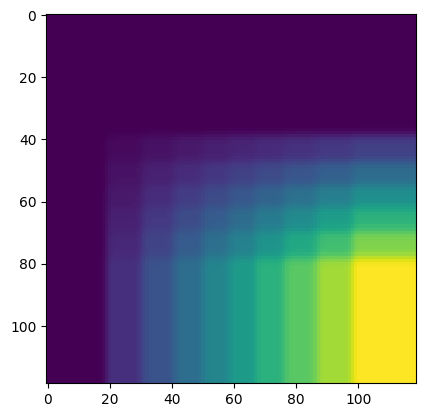

In [399]:
plt.imshow(cdf)

In [400]:
cdf_1d = np.einsum("ij -> j",cdf)
cdf_1d_ext = np.concatenate([[0], cdf_1d/cdf_1d.max()])

In [419]:
x_line = np.linspace(-Wy/2, Wy/2, 800)

In [420]:
def lambertian_vec(sources, t, s, h):
    result = 0
    for si in sources:
        result += lambertian(si, t, s, h)
    return result

In [421]:
N = 14
n = N-1
dn = 1/n
uni_s = [dn * i for i in range(0, n+1)]
#uni_s = np.sort(cheby_root_grid_1(0, 1, N))

# Inverse transform sampling
s_space = np.linspace(-Wy/2, Wy/2, cdf_1d.size+1, endpoint=True)
r = invsam.int_sampling(np.array(uni_s), cdf= cdf_1d_ext/cdf_1d_ext.max(), domain=s_space , interpolate=True)
r = (r/r.max() *Wy)-Wy/2
r_true = (r -np.flip(r))/2 # X

y_line = lambertian_vec(r_true, x_line, s, H)

uniform = np.linspace(-Wy/2, Wy/2, r_true.size, endpoint=True)
y_line_uni = lambertian_vec(uniform, x_line, s, H)

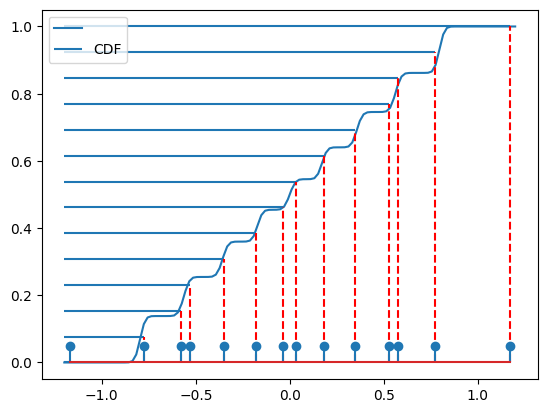

In [422]:
plt.plot(s_space, np.concatenate([[0], cdf_1d/cdf_1d.max()]))
plt.hlines([dn * i for i in range(0, n+1)], xmin=-Wy/2, xmax=r_true)
plt.vlines(r_true, ymin=0, ymax=uni_s, linestyles="--", colors="r")
plt.stem(r_true, 0.05*np.ones(r.size))
plt.legend(["","CDF"])

0.5863815520569651, 0.9738841998793649
0.26336767461648086, 0.01903866392665816


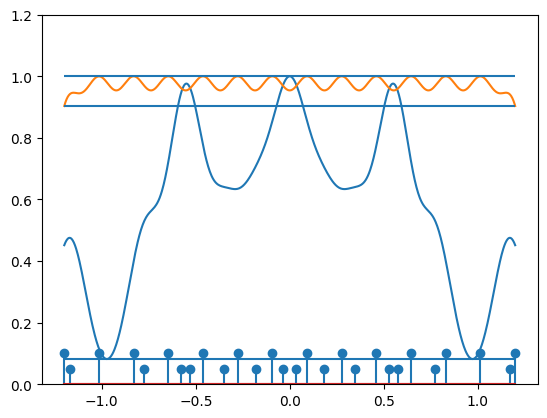

In [423]:
fig, ax = plt.subplots()
normal_bool = True
w1 = y_line_uni.max() if normal_bool else 1
w2 = y_line.max() if normal_bool else 1
y1 = y_line_uni/w1
y = y_line/w2
ax.plot(x_line, y)
ax.plot(x_line, y1)
ax.hlines([y.max(), y.min(), y1.min()], -Wy/2, Wy/2)
#ax.text(0, y.min()-0.1, f"Min: {y.min()}")
if normal_bool:
    ax.set_ylim(0, 1.2)
plt.stem(r_true, 0.05*y1.max()*np.ones(r.size))
plt.stem(uniform, 0.1*y1.max()*np.ones(uniform.size))
print(f"{y.mean()}, {y1.mean()}")
print(f"{y.std()}, {y1.std()}")
